In [1]:
import pandas as pd, numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from tools import networkHelpers as nh 

from tools.dev_hiveplot import hiveplot as hp
from tools import networkHelpers as nh
from copy import copy
from importlib import reload

%matplotlib inline

## Read in HGNC Mapper

In [2]:
hgnc_mapper = nh.fetch_hgnc_mapper()

## Create Louvain clusters

In [3]:
louvain_sub = pd.read_csv('../results/weighted/louvain_small_clusters.txt', sep='\t')
louvain_super = pd.read_csv('../results/weighted/louvain_clusters.txt', sep='\t')
louv= louvain_super.merge(louvain_sub.set_index('names'), how='left', on='names', suffixes=['_super', '_sub'])
louv.head()

,names,cluster_super,cluster_sub
0,MST1R,3,11
1,YES1,3,11
2,TYRO3,3,11
3,FGR,3,11
4,SRC,3,11


## Read in the Graph for connectivity

In [4]:
graph_edges = pd.read_csv('../data/kin/kin_unweighted.csv', sep='\t', header=None)
graph_edges.head()

,0,1
0,MST1R,YES1
1,TYRO3,YES1
2,FGR,SRC
3,ATR,FLT1
4,LYN,PRKCD


In [5]:
graph_edges_duplicate = copy(graph_edges)
graph_edges_duplicate.columns = [1,0]
graph_edges_duplicate = graph_edges_duplicate[[0,1]]
graph_edges_extended= graph_edges.append(graph_edges_duplicate)

In [6]:
graph_edge_dict = graph_edges_extended.groupby(0).agg(lambda x: set(x)).to_dict()[1]
graph_edge_dict.update({x:y|set([x]) for x,y in graph_edge_dict.items()})# make reflexive
next(iter(graph_edge_dict.items()))

('AAK1',
 {'AAK1',
  'CDK1',
  'EGFR',
  'GAK',
  'NTRK1',
  'PIK3C2A',
  'PPIP5K2',
  'STK38',
  'WNK1'})

## Drug targeting

In [7]:
drug_data = pd.read_excel('../data/ref/Klaeger_Science_2017 Supplementary Table 6 Selectivities.xlsx', sheet_name='CATDS target')
drug_data.head()

,Drug,Target,At,CATDS
0,MK-5108,AURKA,0.120921,0.657165
1,PF-477736,CHEK1,0.243725,0.733257
2,Dovitinib,FLT3,0.265240,0.860803
3,Silmitasertib,CSNK2A1;CSNK2A3,0.309017,0.508172
4,Capmatinib,MET,0.337514,1.000000


In [8]:
double_drug_targets = drug_data[drug_data['Target'].apply(lambda x: ';' in x)]
#double_drug_targets.shape

first_genes = double_drug_targets['Target'].apply(lambda x: x.split(';')[0])
second_genes = double_drug_targets['Target'].apply(lambda x: x.split(';')[1])

repaired_double_targets = double_drug_targets.drop('Target', axis=1).assign(**{'Target':first_genes})
repaired_double_targets = repaired_double_targets.append(double_drug_targets.drop('Target', axis=1).assign(**{'Target':second_genes})) 

drug_data = drug_data.drop(double_drug_targets.index).append(repaired_double_targets, sort=False)

# filter to only hgnc keys
drug_data = drug_data[drug_data.Target.isin(hgnc_mapper.keys())]

# convert to hgnc
drug_data.Target = drug_data.Target.apply(lambda x: hgnc_mapper[x])

drug_list = list(sorted(set(drug_data.Drug)))
len(drug_list)

# sort columns
drug_data = drug_data[['Target', 'Drug', 'At', 'CATDS']]
drug_data.head()

,Target,Drug,At,CATDS
0,AURKA,MK-5108,0.120921,0.657165
1,CHEK1,PF-477736,0.243725,0.733257
2,FLT3,Dovitinib,0.265240,0.860803
4,MET,Capmatinib,0.337514,1.000000
5,MAPKAPK2,VX-702,0.342705,0.743594


In [9]:
# filter to kinases present
drug_data = drug_data[drug_data.Target.isin(set(louv['names']))]

# create dicts to map cluster numbers
gene_to_sub_mapper = louv.set_index('names')['cluster_sub'].to_dict()
gene_to_super_mapper = louv.set_index('names')['cluster_super'].to_dict() 

drug_data['cluster_sub'] = drug_data.Target.apply(lambda x: gene_to_sub_mapper[x])
drug_data['cluster_super'] = drug_data.Target.apply(lambda x: gene_to_super_mapper[x])

drug_data.head()

,Target,Drug,At,CATDS,cluster_sub,cluster_super
0,AURKA,MK-5108,0.120921,0.657165,2,2
1,CHEK1,PF-477736,0.243725,0.733257,2,2
2,FLT3,Dovitinib,0.265240,0.860803,11,3
4,MET,Capmatinib,0.337514,1.000000,11,3
5,MAPKAPK2,VX-702,0.342705,0.743594,3,7


## Functionalized plotting and coloring

In [10]:
understudied = set(pd.read_csv('../data/ref/dark_kinases.csv')['symbol'])

print(understudied)

{'NEK5', 'TBCK', 'EEF2K', 'STK38L', 'ADCK2', 'TSSK2', 'TESK2', 'STK31', 'CDK11B', 'STK17A', 'DYRK2', 'DSTYK', 'MAPK4', 'STK32A', 'CAMKV', 'MAPK15', 'NIM1K', 'PIP5K1B', 'PSKH1', 'NRBP2', 'CSNK1G3', 'CDK14', 'MAP3K21', 'PIK3C2B', 'ADCK5', 'CDC42BPA', 'BRSK1', 'NEK6', 'RNASEL', 'MARK1', 'ADCK1', 'DYRK4', 'STK3', 'SCYL3', 'PAN3', 'STK19', 'HIPK3', 'TTBK1', 'TTBK2', 'ALPK2', 'CAMKK2', 'NEK7', 'ALPK3', 'CDK13', 'CDKL5', 'MKNK1', 'PXK', 'MAST3', 'ULK4', 'CAMK1G', 'PRKACB', 'COQ8A', 'NEK9', 'NEK1', 'SBK3', 'LMTK2', 'TLK1', 'TP53RK', 'CDKL1', 'TSSK3', 'PRKCQ', 'STK33', 'CSNK1G2', 'MAP3K14', 'MKNK2', 'STK32C', 'MAP3K15', 'STK40', 'TSSK4', 'RIOK3', 'LMTK3', 'PIK3C2G', 'CDKL2', 'SCYL2', 'CDK17', 'CSNK2A3', 'CDKL4', 'NEK10', 'COQ8B', 'WNK3', 'LRRK1', 'RPS6KC1', 'CDK19', 'CAMKK1', 'VRK3', 'PIP4K2C', 'CDK12', 'CDK18', 'MARK3', 'WEE2', 'PIP5K1A', 'PRKACG', 'CDC42BPB', 'MAST2', 'PAK6', 'TAOK2', 'NUAK2', 'SBK1', 'NEK11', 'POMK', 'MARK4', 'RIOK2', 'TLK2', 'CDK10', 'TAOK1', 'CAMK1D', 'CSNK1A1L', 'CDK16', 

### Overwrite family data to supercluster assignments

In [11]:
## set to supercluster number
kinase_family_data = louv.set_index('names')['cluster_super']

In [12]:
def plot_sub_super_hiveplot(sub_clust_no, super_clust_no, fig, ax, kinase_family_data, axis_pad=None):
    nodes = {}
    
    nodes['kinome'] = []
    all_families = set(kinase_family_data)
    for i,family in enumerate(all_families):
        nodes.update({'kinome':nodes['kinome']+[('kinome_'+x,x) for x in list(louv[louv.cluster_super==family].sort_values(by='cluster_sub').names)]+[('kinome_'+str(j),'empty'+str(j), 'empty') for j in range(i*len(louv.names)//25,(i+1)*len(louv.names)//25)] if i < len(all_families) else []})
    
    
    #nodes['kinome'] = [('kinome_'+x,x) for x in louv.names]
    nodes['drug'] = [('drug_'+x,x) for x in drug_list]
    
    super_cluster_size = len(louv[louv.cluster_super == super_clust_no])
    sub_cluster_size = len(louv[louv.cluster_sub == sub_clust_no])
    superkinase_to_sub_clust_id_dict = louv[louv.cluster_super == super_clust_no].set_index('names').cluster_sub.to_dict()

    # add the understudied kinases last, as we reverse
    nodes['sub'] = [('sub_'+x,x,'well') for x,z in zip(louv.names, louv.cluster_sub) if z == sub_clust_no and x not in understudied]
    nodes.update({'sub':nodes['sub']+[('sub_empty'+str(i),'empty'+str(i),'empty') for i in range(0,sub_cluster_size//15+1)]}) # add empty divider proportiona to length
    nodes.update({'sub':nodes['sub']+[('sub_'+x,x,'under') for x,z in zip(louv.names, louv.cluster_sub) if z == sub_clust_no and x in understudied]})
    
    #print(nodes['sub'])
    nodes['super'] = []
    set_of_subclusts_in_superclust = list(louv[louv.cluster_super == super_clust_no].cluster_sub.unique())
    sub_clust_id_dict = {x:y for y,x in enumerate(set_of_subclusts_in_superclust)}
    
    for i, sub_clust_in_super in enumerate(set_of_subclusts_in_superclust):
        #print(i)
        nodes.update({'super':nodes['super']+[('super_'+x,x,i) for x,y,z in zip(louv.names, louv.cluster_super, louv.cluster_sub) if y == super_clust_no and z == sub_clust_in_super]+[('super_empty'+str(j),'empty'+str(j),'empty') for j in range(i*sum(louv.cluster_super==super_clust_no)//20, (i+1)*sum(louv.cluster_super==super_clust_no)//20)]})

    # get the supercluster genes
    louv_super_names = set(louv[louv.cluster_super == super_clust_no].names)
    drug_sub_hits = copy(drug_data[drug_data.cluster_sub == sub_clust_no])
    present_drug_set = set(drug_sub_hits.Drug)
    present_drug_list = list(present_drug_set)

    # compute mean CATDS
    mean_drug_catds = (drug_sub_hits.groupby('Drug')['CATDS'].agg(sum)/drug_sub_hits.groupby('Drug')['CATDS'].agg(len)).to_dict()

    # sort present drugs by catds
    try:
        sorted_present_drugs, ___ = zip(*sorted(zip(present_drug_list, [mean_drug_catds[x] for x in present_drug_list]), key = lambda x: x[1]))
    except:
        sorted_present_drugs = []

    sorted_present_drugs = list(sorted_present_drugs)

    # sort the drugs by 1) presence 2) selectivity
    drugs_not_present = list(set(drug_list) - set(present_drug_set))

    #nodes.update({'drug':[('drug_'+x,x) for x in drugs_not_present + sorted_present_drugs]})
    nodes.update({'drug':[('drug_'+x,x) for x in list(reversed(sorted_present_drugs)) + drugs_not_present]})

    # calculate total drug hits of present drugs
    total_drug_hits = drug_data[drug_data.Drug.isin(present_drug_set)]
    total_drug_hit_sets = total_drug_hits.groupby('Drug')['Target'].agg(lambda x: set(x)).to_dict()

    edges = {}
    edges['sub_super'] = [(sub_node,('super_'+super_node, super_node, sub_clust_id_dict[superkinase_to_sub_clust_id_dict[super_node]]),1) for sub_node in nodes['sub'] if 'empty' != sub_node[2] for super_node in graph_edge_dict[sub_node[1]] if super_node in louv_super_names]
    edges['super_kinome'] = [(super_node,('kinome_'+kin_node, kin_node),1) for super_node in nodes['super'] if super_node[2] != 'empty' for kin_node in graph_edge_dict[super_node[1]]]
    edges['sub_kinome'] = [(('super_'+sub_node[1],sub_node[1], sub_clust_id_dict[superkinase_to_sub_clust_id_dict[sub_node[1]]]),('kinome_'+kin_node, kin_node),1) for sub_node in nodes['sub'] if 'empty' != sub_node[2] for kin_node in graph_edge_dict[sub_node[1]]]
    
    # create understudied status dict for drug_sub hits
    understudied_status_dict = {x:'well' for x,z in zip(louv.names, louv.cluster_sub) if z == sub_clust_no and x not in understudied}
    understudied_status_dict.update({x:'under' for x,z in zip(louv.names, louv.cluster_sub) if z == sub_clust_no and x in understudied})
    
    edges['drug_sub'] = [(('drug_'+drug,drug), ('sub_'+target,target,understudied_status_dict[target]), at_value) for drug,target,at_value in zip(drug_sub_hits.Drug, drug_sub_hits.Target, -np.log(drug_sub_hits.At.values))]
    edges['drug_kin'] = [(('drug_'+drug,drug), ('kinome_'+kin_node,kin_node), 1) for drug in sorted_present_drugs for kin_node in total_drug_hit_sets[drug]]

    #print(edges['drug_sub'])
    
    # filter the sub_kinome connections from the super_kinome connections
    edges['super_kinome'] = list(filter(lambda x: x not in edges['sub_kinome'], edges['super_kinome']))

    nodes_cmap = dict()
    nodes_cmap['kinome'] = lambda x: 'white' if x[0][1] == 'empty' else 'black'
    nodes_cmap['drug'] = 'black'
    
    sub_color_dict = {'empty':'white', 'under':'blue', 'well':'black'}
    nodes_cmap['sub'] = lambda x: sub_color_dict[x[2]]
    
    #print(len(set_of_subclusts_in_superclust))
    #len(set_of_subclusts_in_superclust)*1.0
    nodes_cmap['super'] = lambda x: cm.jet(x[2]*1.0/(len(set_of_subclusts_in_superclust)*1.0)) if x[2] != 'empty' else 'white'

    edges_cmap = dict()
    edges_cmap['sub_super'] = lambda x: 'blue' if x[0][2] is 'under' else 'orange'
    edges_cmap['sub_kinome'] = lambda x: 'blue' if x[0][1] in understudied else 'orange'
    edges_cmap['super_kinome'] = 'black'
    edges_cmap['drug_sub'] = 'red'
    edges_cmap['drug_kin'] = lambda x: 'purple' if x[1][1] not in understudied else 'red'

    d, k, S, s = (len(drug_list),len(louv.names.unique()), len(louv_super_names), len(nodes['sub']))
    d, k, S, s = list(map(lambda x:(np.log(x)+1)/x, [d, k, S, s]))
    
    group_scale = {}
    group_scale['kinome'] = k/s
    group_scale['super'] = S/s
    group_scale['drug'] = d/s
    group_scale['sub'] = 1.0
    
    group_reverse = {}
    group_reverse['kinome'] = False
    group_reverse['super'] = True
    group_reverse['drug'] = True
    group_reverse['sub'] = True
    
    h = hp.HivePlot(nodes, edges, nodes_cmap, edges_cmap, fig=fig, ax=ax, group_scale=group_scale, reverse_to_expand=group_reverse, skip_within=True, axis_pad=axis_pad)
    h.draw()
    
    return h


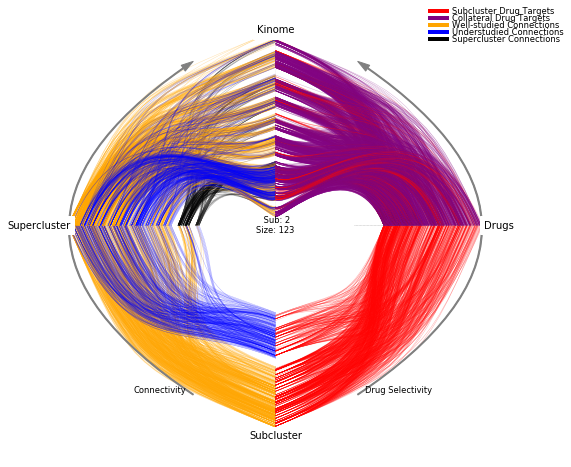

In [13]:
import matplotlib.lines as lines
import matplotlib.patches as patches
fig, ax = plt.subplots(ncols=1,nrows=1, figsize=(8,8))

h = plot_sub_super_hiveplot(sub_clust_no=2, super_clust_no=2, 
                            fig=fig, ax=ax, 
                            kinase_family_data = kinase_family_data, 
                            axis_pad=180)

kin_height = np.log(len(louv.names)+(len(louv.names)//25*9))*10

import matplotlib.collections  as mc
#bars = [[(0,plt.xlim()[1]-100), (0,plt.ylim())], [(0,plt.xlim()[0]+100), (0,plt.ylim())]]


lines = [[(plt.xlim()[1]-790, plt.ylim()[1]-40), (plt.xlim()[1]-550, plt.ylim()[1]-40)],
         [(plt.xlim()[1]-790, plt.ylim()[1]-200), (plt.xlim()[1]-550, plt.ylim()[1]-200)],
         [(plt.xlim()[1]-790, plt.ylim()[1]-280), (plt.xlim()[1]-550, plt.ylim()[1]-280)],
         [(plt.xlim()[1]-790, plt.ylim()[1]-360), (plt.xlim()[1]-550, plt.ylim()[1]-360)],
         [(plt.xlim()[1]-790, plt.ylim()[1]-120), (plt.xlim()[1]-550, plt.ylim()[1]-120)]]

c = np.array(['red',
              'orange',
              'blue',
              'black', 
              'purple'])


# connections
ax.text(x=plt.xlim()[1]-520, y=plt.ylim()[1]-200, s='Well-studied Connections', color='black', verticalalignment='center', fontsize='small')
ax.text(x=plt.xlim()[1]-520, y=plt.ylim()[1]-280, s='Understudied Connections', color='black', verticalalignment='center', fontsize='small')
ax.text(x=plt.xlim()[1]-520, y=plt.ylim()[1]-360, s='Supercluster Connections', color='black', verticalalignment='center', fontsize='small')

# drug targets
ax.text(x=plt.xlim()[1]-520, y=plt.ylim()[1]-40, s='Subcluster Drug Targets', color='black', verticalalignment='center', fontsize='small')
ax.text(x=plt.xlim()[1]-520, y=plt.ylim()[1]-120, s='Collateral Drug Targets', color='black', verticalalignment='center', fontsize='small')

lc = mc.LineCollection(lines, colors=c, linewidths=4)
#fig, ax = pl.subplots()
ax.add_collection(lc)

style="Simple,tail_width=1,head_width=7,head_length=12"
kw = dict(arrowstyle=style, color="gray")

arrow1 = patches.FancyArrowPatch((-900,plt.ylim()[0]+540), (-900,plt.ylim()[1]-600), connectionstyle="arc3,rad=-.75", **kw)
arrow2 = patches.FancyArrowPatch((900,plt.ylim()[0]+540), (900,plt.ylim()[1]-600), connectionstyle="arc3,rad=.75", **kw)

ax.text(x=0, y=plt.ylim()[1]- 250, s='Kinome', color='black', horizontalalignment='center', verticalalignment='center', fontsize='medium', bbox=dict(facecolor='white', edgecolor='white'))
ax.text(x=0, y=plt.ylim()[0]+ 80, s='Subcluster', color='black', horizontalalignment='center', verticalalignment='center', fontsize='medium', bbox=dict(facecolor='white',edgecolor='white'))
ax.text(x=plt.xlim()[0]-150, y=0, s='Supercluster', color='black', horizontalalignment='center', verticalalignment='center', fontsize='medium', bbox=dict(facecolor='white',edgecolor='white'))
ax.text(x=plt.xlim()[1], y=0, s='Drugs', color='black', horizontalalignment='center', verticalalignment='center', fontsize='medium', bbox=dict(facecolor='white',edgecolor='white'))

# arrow texts
ax.text(x=-1000, y=plt.ylim()[0]+600, s='Connectivity', color='black', horizontalalignment='right', verticalalignment='center', fontsize='small')
ax.text(x=1000, y=plt.ylim()[0]+600, s='Drug Selectivity', color='black', verticalalignment='center', fontsize='small')

ax.add_patch(arrow1)
ax.add_patch(arrow2)

ax.text(x=0,y=0, s=' Sub: 2\nSize: '+str(len(louv[louv.cluster_sub==2])),color='black', horizontalalignment='center', verticalalignment='center', fontsize='small')

plt.savefig('../viz/images/png/subc_2.png')
plt.savefig('../viz/images/pdf/subc_2.pdf')
plt.show()


In [14]:
super_sub_listing = louv.groupby('cluster_super')['cluster_sub'].agg(lambda x: set(x)).to_dict()
super_sub_listing

{1: {7, 8, 21},
 2: {2, 9, 24},
 3: {11},
 4: {1, 16, 19},
 5: {13, 15},
 6: {4, 6, 10, 14, 17, 18, 22, 23, 25},
 7: {3},
 8: {5, 12, 20},
 9: {26}}

In [15]:
line_count = 0
div_count = 7
for sup_ in super_sub_listing:
    line_count += 1 + len(super_sub_listing[sup_])//3
print(line_count)
print(div_count+line_count)

16
23


In [16]:
sub_size_mapper = louv.groupby('cluster_sub').count()['names'].to_dict()
sub_size_mapper

{1: 52,
 2: 123,
 3: 63,
 4: 9,
 5: 21,
 6: 8,
 7: 17,
 8: 19,
 9: 14,
 10: 3,
 11: 75,
 12: 5,
 13: 31,
 14: 12,
 15: 9,
 16: 3,
 17: 15,
 18: 9,
 19: 3,
 20: 2,
 21: 4,
 22: 2,
 23: 4,
 24: 5,
 25: 2,
 26: 7}

Super:  1
Sub:  8
Sub:  21
Sub:  7
Super:  2
Sub:  24
Sub:  9
Sub:  2
Super:  3
Sub:  11
Blanking:  4 1
Blanking:  4 2
Super:  4
Sub:  16
Sub:  1
Sub:  19
Super:  5
Sub:  13
Sub:  15
Blanking:  8 2
Super:  6
Sub:  4
Sub:  6
Sub:  10
Sub:  14
Sub:  17
Sub:  18
Sub:  22
Sub:  23
Sub:  25
Super:  7
Sub:  3
Blanking:  14 1
Blanking:  14 2
Super:  8
Sub:  20
Sub:  12
Sub:  5
Super:  9
Sub:  26
Blanking:  18 1
Blanking:  18 2


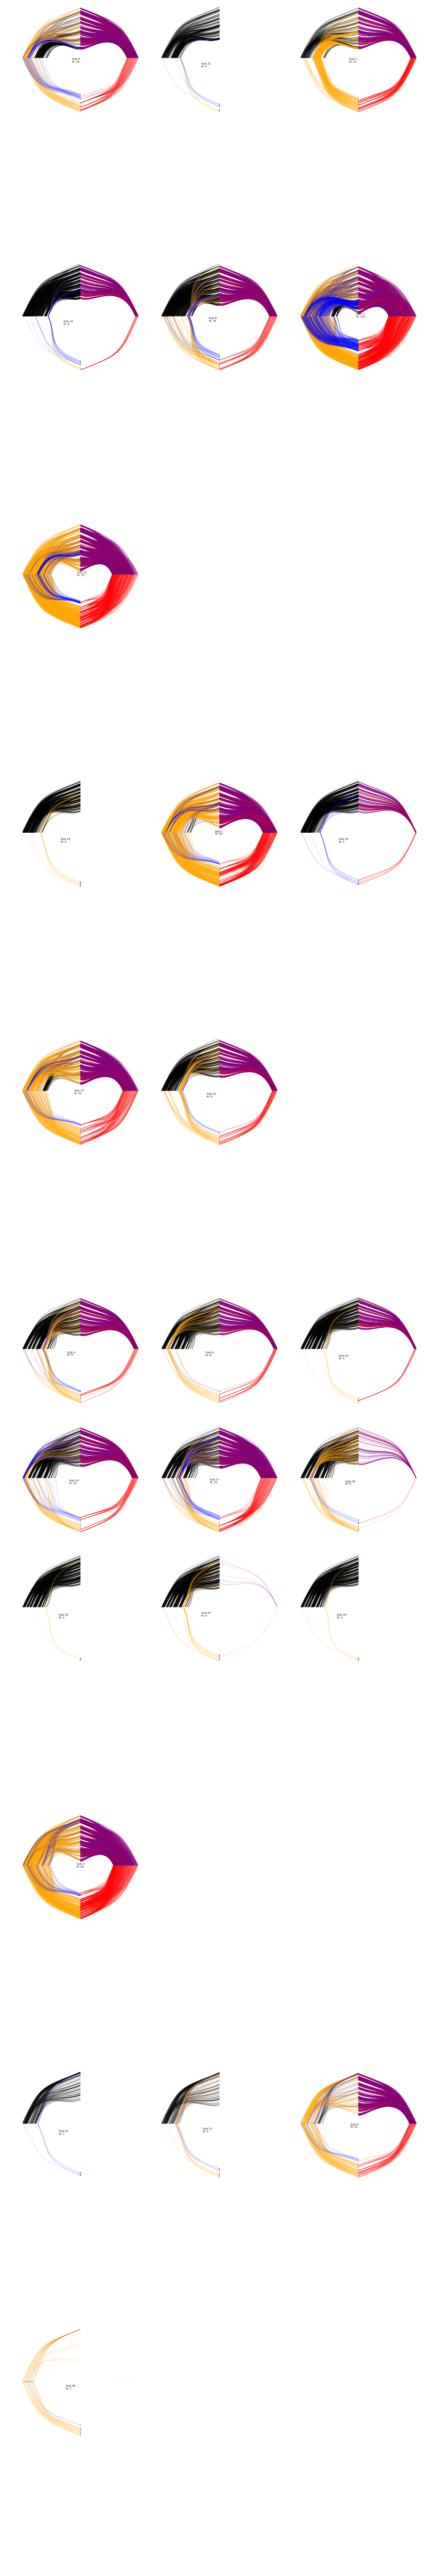

In [17]:
fig, axes = plt.subplots(ncols=3,nrows=20, figsize=(15,100))

row_tracker = 0
column_tracker = 0

for sup_ in super_sub_listing.keys():
    print('Super: ', sup_)
    for sub_ in super_sub_listing[sup_]:
        print('Sub: ', sub_)
        if(column_tracker >= 3 and column_tracker % 3 == 0):
            row_tracker +=1
        ax = axes[row_tracker][column_tracker%3]
        ax.clear()
        
        plot_sub_super_hiveplot(sub_clust_no=sub_, super_clust_no=sup_, fig=fig, kinase_family_data=kinase_family_data, ax=ax)
        ax.text(x=-90,y=-50, s='Sub '+str(sub_)+'\nN: '+str(sub_size_mapper[sub_]),color='black',fontsize='xx-small')
        
        column_tracker+=1
        
    while(column_tracker % 3 != 0):
        print('Blanking: ', row_tracker, column_tracker)
        axes[row_tracker][column_tracker%3].axis('off')
        column_tracker += 1
    
    column_tracker = 0        
    
    # blank the next row
    for i in range(3):
        axes[row_tracker+1][i].axis('off')
    
    #skip the blank row
    row_tracker += 2
        

#h.draw()
plt.savefig('../viz/images/pdf/cluster_hive_panel.pdf')

### Multiple pages

In [18]:
from matplotlib.backends.backend_pdf import PdfPages

with PdfPages('../viz/images/pdf/multipage_cluster_hive_panel.pdf') as pdf:
    fig, axes = plt.subplots(ncols=3,nrows=6, figsize=(16,28))
    
    sup_grouping = [[1,2,3], [4,5], [6], [7,8,9]]
    
    for group in sup_grouping:
        row_tracker = 0
        column_tracker = 0

        for sup_ in group:
            print('Super: ', sup_)
            for sub_ in super_sub_listing[sup_]:
                print('Sub: ', sub_)
                if(column_tracker >= 3 and column_tracker % 3 == 0):
                    row_tracker +=1
                ax = axes[row_tracker][column_tracker%3]
                ax.clear()

                plot_sub_super_hiveplot(sub_clust_no=sub_, super_clust_no=sup_, fig=fig, kinase_family_data=kinase_family_data, ax=ax)
                ax.text(x=-90,y=-50, s='Sub '+str(sub_)+'\nN: '+str(sub_size_mapper[sub_]),color='black',fontsize='xx-small')

                column_tracker+=1

            while(column_tracker % 3 != 0):
                print('Blanking: ', row_tracker, column_tracker)
                axes[row_tracker][column_tracker%3].axis('off')
                column_tracker += 1

            column_tracker = 0        

            # blank the next row
            for i in range(3):
                axes[row_tracker+1][i].axis('off')

            #skip the blank row
            row_tracker += 2
            
    pdf.savefig()  # save current fig
    plt.close()
        

Super:  1
Sub:  8
Sub:  21
Sub:  7
Super:  2
Sub:  24
Sub:  9
Sub:  2
Super:  3
Sub:  11
Blanking:  4 1
Blanking:  4 2
Super:  4
Sub:  16
Sub:  1
Sub:  19
Super:  5
Sub:  13
Sub:  15
Blanking:  2 2
Super:  6
Sub:  4
Sub:  6
Sub:  10
Sub:  14
Sub:  17
Sub:  18
Sub:  22
Sub:  23
Sub:  25
Super:  7
Sub:  3
Blanking:  0 1
Blanking:  0 2
Super:  8
Sub:  20
Sub:  12
Sub:  5
Super:  9
Sub:  26
Blanking:  4 1
Blanking:  4 2
